# EDA

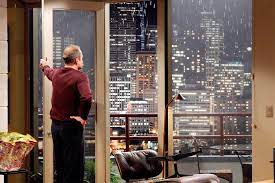

This notebook documents the import, cleaning and exploration of the King County data set. The task is to look for 'socially responsible' investment possibilities based on this data set.

## Download the Data

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

First we load the data from the server and save a local copy. The DB parameters are stored in a hidden file `.env` as a list of shell environment variables. Note that the =.env= file has to be ignored by git so that it will not be uploaded to Microsoft. 

In [ ]:
import psycopg2
import os
from dotenv import load_dotenv

load_dotenv(override=True)

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

def get_connection():
    """Return a connection to the DB."""
    return psycopg2.connect(
        database=DATABASE,
        user=USER_DB,
        password=PASSWORD,
        host=HOST,
        port=PORT
    )



We query the EDA database using SQL:

In [ ]:
conn = get_connection()
cur = conn.cursor()
cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema='eda'")
print(cur.fetchall())
conn.close()

[('king_county_house_sales',), ('king_county_house_details',)]


We read both tables and their inner join unmodified, since we don't know yet what subsets we'll need. It is assumed we already know the structure of the database.

In [ ]:
queries = {'sales': 'SELECT * FROM eda.king_county_house_sales ORDER BY date',
           'details': 'SELECT * FROM eda.king_county_house_details ORDER BY id',
           'sales_with_details': 'SELECT * FROM eda.king_county_house_details AS d \
             JOIN eda.king_county_house_sales AS s ON d.id=s.house_id ORDER BY s.date'}



We load the data from the SQL server in three dataframes and give some rough feedback on what has been queried:

In [286]:
conn=get_connection()
df_sales = pd.read_sql(queries['sales'], conn)    
df_details = pd.read_sql(queries['details'], conn)    
df_detailed_sales = pd.read_sql(queries['sales_with_details'], conn)    
conn.close()

print("Sales shape:", df_sales.shape, "\n",
      "Details shape:", df_details.shape, "\n",
      "Detailed Sales shape:", df_detailed_sales.shape, "\n")

Sales shape: (21597, 4) 
 Details shape: (21420, 19) 
 Detailed Sales shape: (21597, 23) 



 The following cell is just for making a local copy. To avoid running it by accident, it is 'turned off'.


In [287]:
if False:
    conn = get_connection()
    for name, query in queries.items():
        print(f"Downloading {name} to local csv...")
        pd.read_sql(query, conn).to_csv(f"data/{name}.csv")
    conn.close()

## Hypotheses

The task is to give advice to Erin Robinson. Her needs are described as follows:

> Invest in poor neighborhood, buying & selling, costs back + little profit, socially > responsible     

These are points of interest for Erin:
 - Is the neighbourhood 'poor'?
 - How much profit is to be expected when reselling the house?
 - How likely it is that the house can be resold?
 - Is it possible to house many people for relatively little money?
 - Is the house in a decent condition so that the buyers don't have to invest in it after buying it?
 
Assumptions:
 - Larger houses are more expensive.
 - More bathrooms make a house more expensive.
 - Bigger lots make a house more expensive.
 - A poorer neighbourhood has smaller houses.
 - A poorer neighbourhood has houses with an overall lower grading and condition. 
 - A poorer neighbourhood has more neighbouring houses with smaller size.
 - A poorer neighbourhood has smaller lots.

Hypothesis: 
 - Good price indicators are: "grade", "condition", "size (house + lot)" and "bathroom"
   - There is a (strong?) correlation between "grade" and "condition".
   - There is a (strong?) correlation between "overall size" and price
   - There is a (strong?) correlation between "# of bathrooms" and price
   - There is a (strong?) correlation between "grade/condition", "overall size", "# bathrooms" and price
 - Prices (per sqf) are low in areas where neighbour's houses are small, in comparison to areas where neighbour's houses are big.
  - There is a correlation between "size_15" and the price
 - House prices are clustered geographically, forming a 'neighbourhood'.
  - House prices with the same ZIP code have low variance
  - House prices with the ZIP code sharing the last two digits have low variance (but bigger than with the same ZIP code) 
 - A house can be sold better in neighbourhoods with more sales.
 - A "socially responsible" customer prefers lower to mid-range offers. 

 

## Search targets

 - Offer houses in 'poor neighbourhoods'
 - Limit to those houses with acceptable conditions (building grade between 3 and 5, building conditions greater than 7)
 - ??

## Test for Integrity

- Is the total number of living space equal to the size of the basement + the size of 'above'?
- Do the relevant columns have all correct values? Are there any NULLs or ill-formatted values? 

In [288]:
# Check column names
print(df_sales.columns, df_details.columns, df_detailed_sales.columns)

Index(['date', 'price', 'house_id', 'id'], dtype='object') Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object') Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'date', 'price', 'house_id', 'id'],
      dtype='object')


In [289]:
# Check for duplicates:
print(any(df_sales.duplicated()),
      any(df_details.duplicated()),
      any(df_detailed_sales.duplicated()))

False False False


In [290]:
# Test if there are missing values:
df_detailed_sales.isna().sum()


id                  0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2391
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     452
yr_built            0
yr_renovated     3848
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
date                0
price               0
house_id            0
id                  0
dtype: int64

We see that there are four columns with missing values: `waterfront`, `yr_renovated`, `sqft_basement` and `view`. 


Before we dive deeper into these feature, let's check if the ZIPCODES are well formatted:

In [291]:
df_details['zipcode'].unique()

array([98002, 98166, 98168, 98144, 98178, 98108, 98032, 98055, 98118,
       98122, 98115, 98007, 98034, 98052, 98042, 98040, 98136, 98126,
       98146, 98188, 98059, 98109, 98116, 98103, 98006, 98075, 98024,
       98155, 98003, 98023, 98117, 98177, 98019, 98028, 98092, 98022,
       98070, 98038, 98107, 98106, 98065, 98053, 98072, 98077, 98133,
       98001, 98056, 98045, 98033, 98011, 98014, 98199, 98008, 98031,
       98004, 98074, 98030, 98027, 98029, 98058, 98010, 98005, 98198,
       98148, 98112, 98125, 98105, 98102, 98119, 98039])

Looking good!

## Clean the data

In [292]:
# Set missing "sqft_basement" to 0
df_details['sqft_basement'].fillna(0, inplace=True)
df_details[df_details['sqft_basement'].isna()].shape[0]

0

In [293]:
df_detailed_sales.columns

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'date', 'price', 'house_id', 'id'],
      dtype='object')

## Explore the Data

Let's check how many houses there are at all per ZIPCODE:

In [294]:
df_details.groupby('zipcode').count()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
zipcode,,,,,,,,,,,,,,,,,,
98001,358,358,358,358,358,358,325,356,358,358,358,358,358,281,358,358,358,358
98002,197,197,197,197,197,197,178,197,197,197,197,197,197,163,197,197,197,197
98003,276,276,276,276,276,276,251,276,276,276,276,276,276,238,276,276,276,276
98004,315,315,315,315,315,315,281,314,315,315,315,315,315,261,315,315,315,315
98005,168,168,168,168,168,168,158,168,168,168,168,168,168,138,168,168,168,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98177,254,254,254,254,254,254,234,253,254,254,254,254,254,204,254,254,254,254
98178,258,258,258,258,258,258,229,258,258,258,258,258,258,207,258,258,258,258
98188,135,135,135,135,135,135,118,135,135,135,135,135,135,111,135,135,135,135


### Grade / Condition

In [295]:
print(df_details['grade'].unique(),"\n", df_details['condition'].unique())

[ 7  8  6  9  5 10 11 12  4 13  3] 
 [3 4 5 2 1]


In [296]:
print(df_sales['date'].min(), df_sales['date'].max())

2014-05-02 2015-05-27


The ordinal value for `condition` has a range from 1 to 5; whereas the `grade` varies from 3 to 13. Let's assume that there no lower values because there are not sold in the time period covered (2014-2015). So we have a range from 0 to 13, possibly more.

Using [this](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) explanation ,  we can set the criteria for our houses which do not need much repair:

`condition` >= 3
`grade` >= 7

<Axes: xlabel='condition', ylabel='count'>

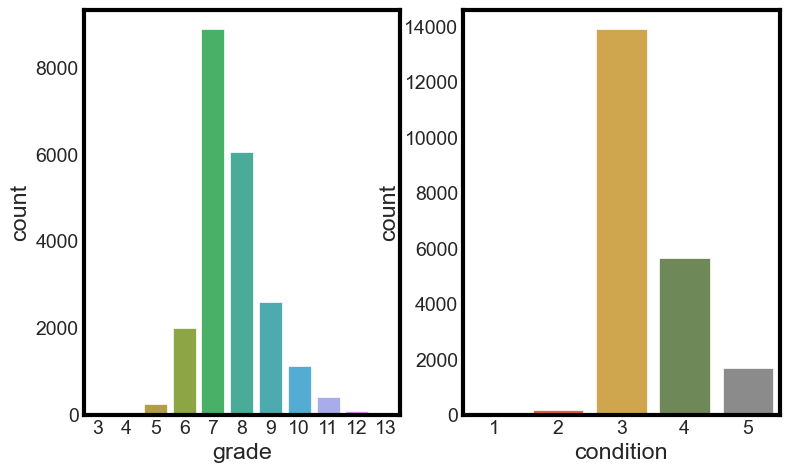

In [297]:
# Explore how many houses there are for each category (grade / condition)

#df_details['grade'].value_counts()

fig, ax = plt.subplots(1,2)
sns.countplot(df_details, x='grade', ax=ax[0])
sns.countplot(df_details, x='condition', ax=ax[1])

Condition >=3 and Grade >=7 do not exclude many houses. 

How about the price distribution per grade / condition? We want a boxplot for each category, plotting the distribution of the price within in this category.

<Axes: ylabel='price'>

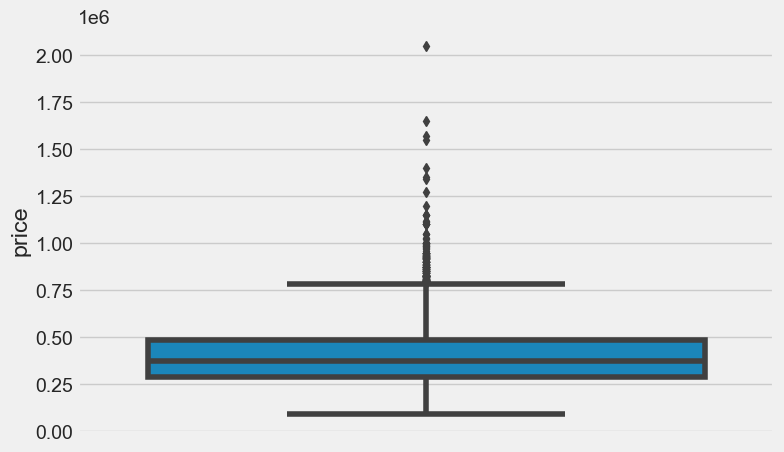

In [298]:
plt.style.use('fivethirtyeight') 
sns.boxplot(df_detailed_sales[df_detailed_sales['grade'] == 7], y='price')

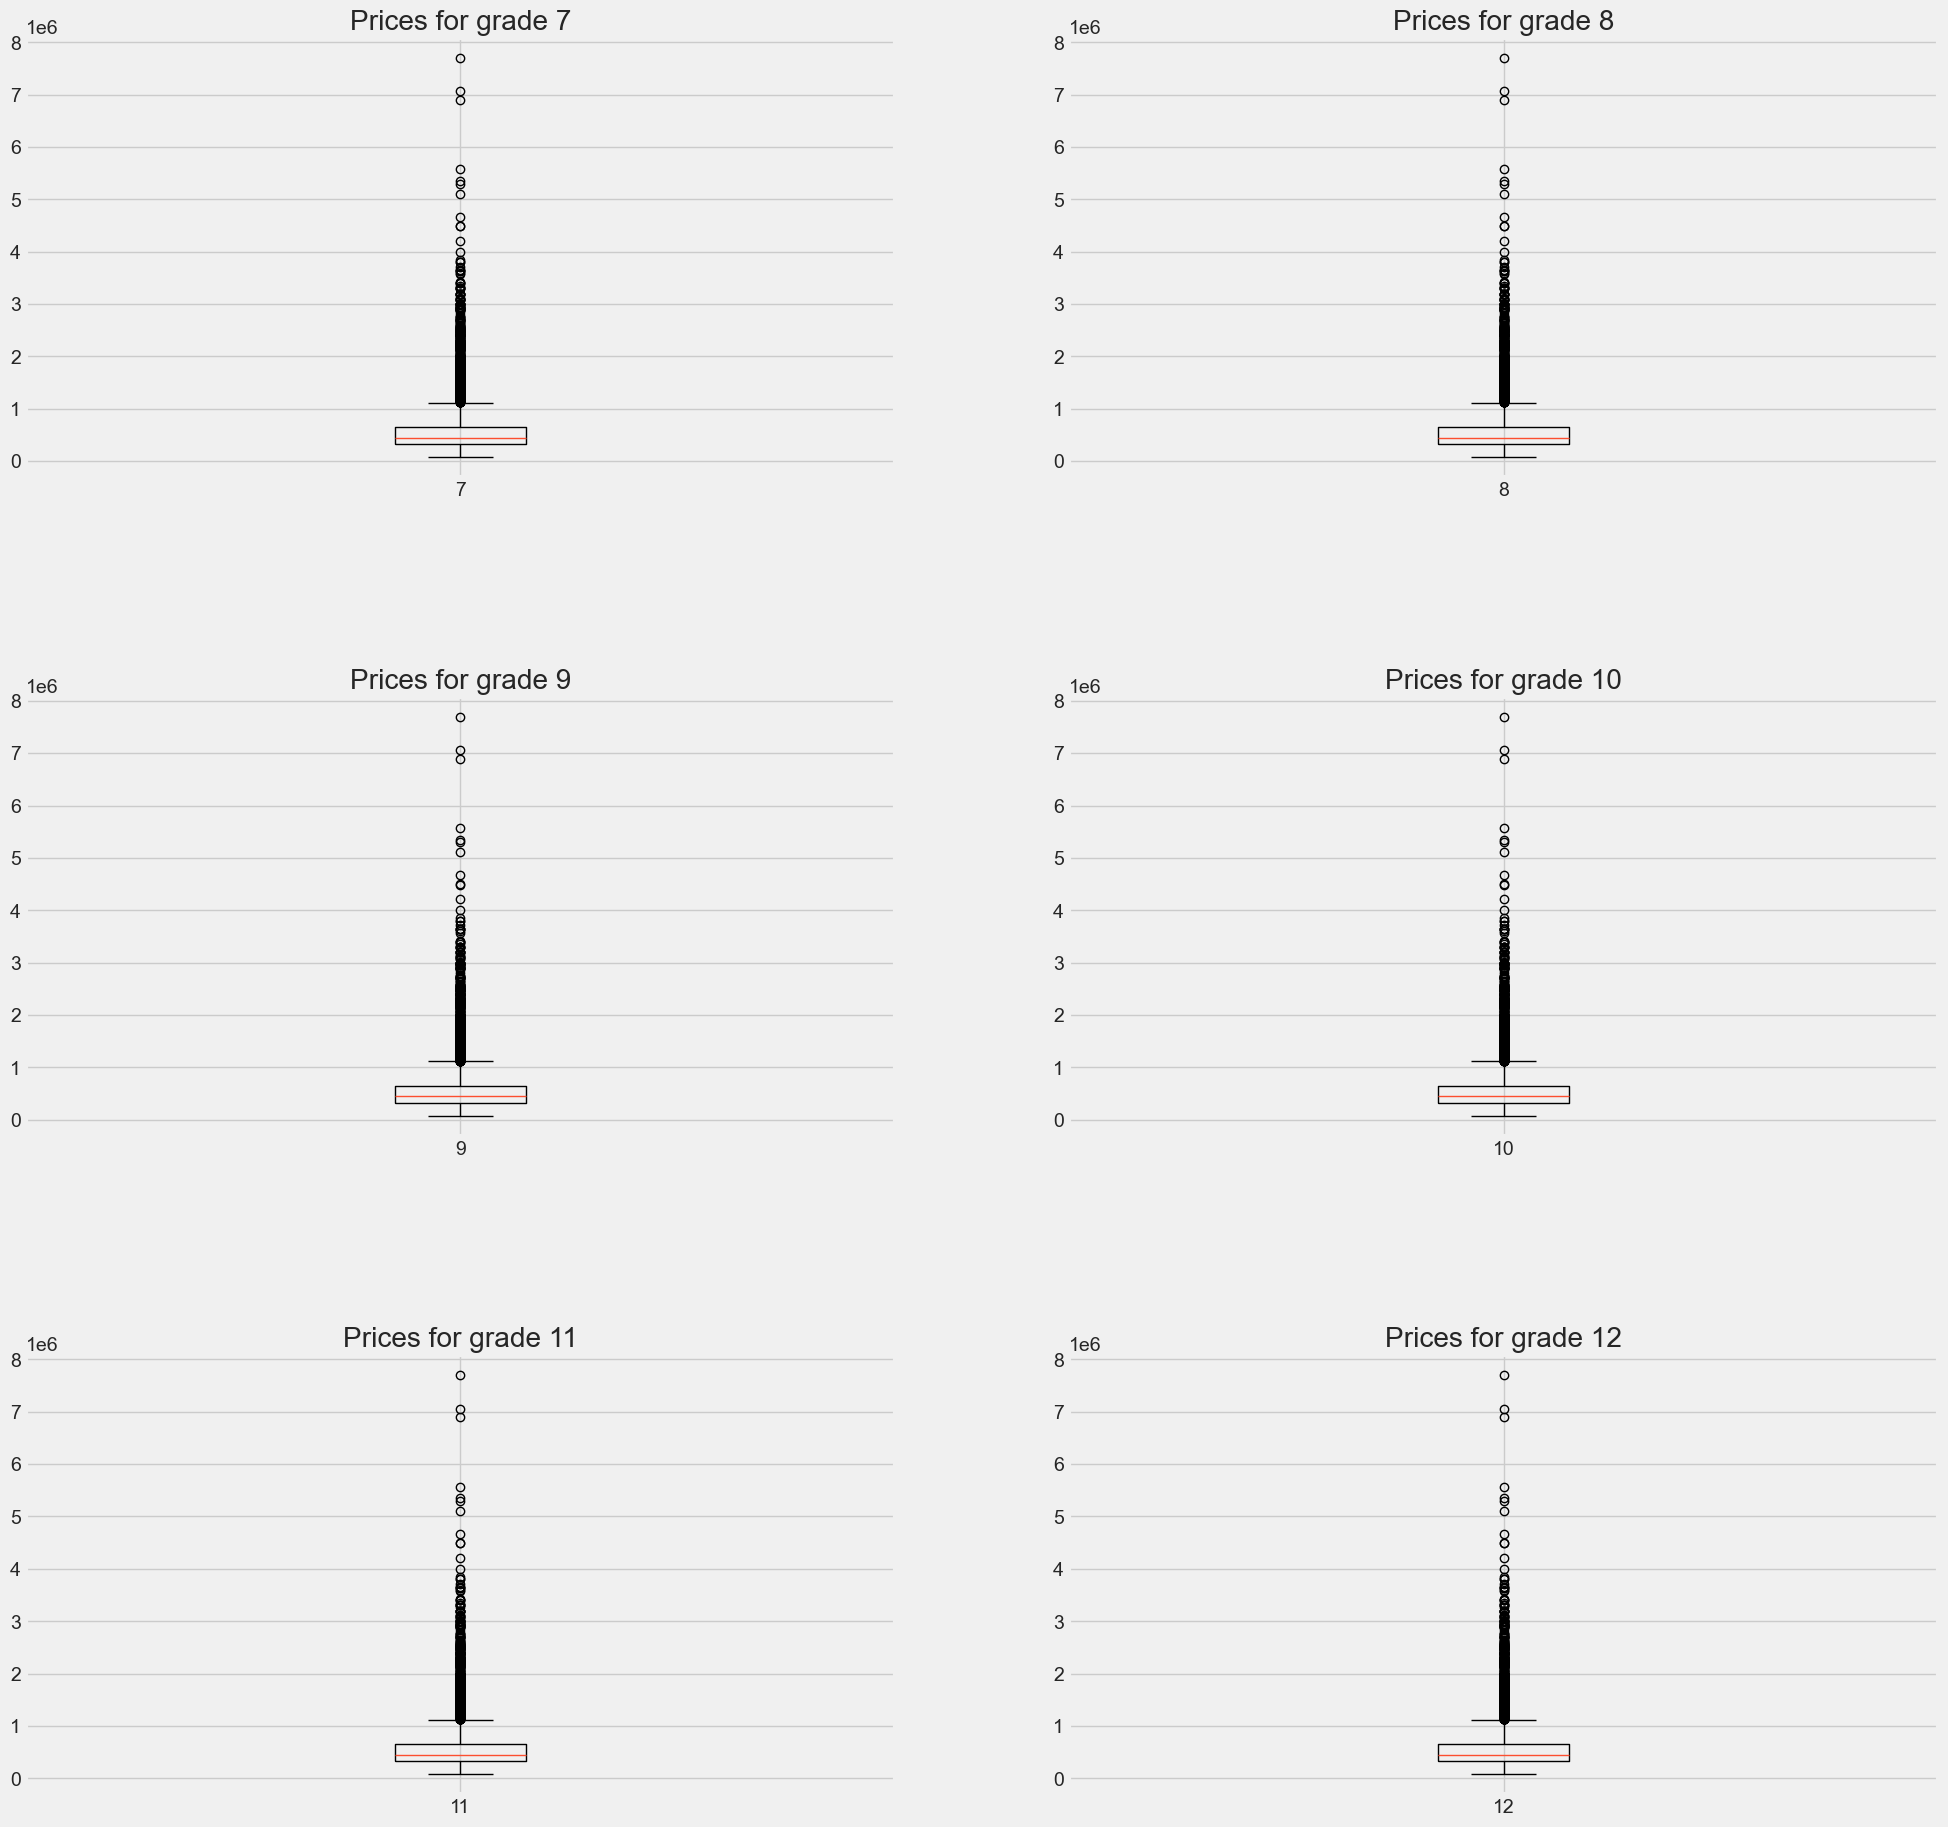

In [299]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(3,2, figsize=(20,20))
fig.tight_layout()
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) # adjusts the space between the single subplots

ax_counter = 0 
pos = [ (x,y) for x in range(3) for y in range(2)]
for i in range(7,13):
    df_temp = df_detailed_sales[df_detailed_sales['grade'] == i]
    x, y = pos[ax_counter]
    ax[x][y].boxplot(x=df_detailed_sales['price'])
    ax[x][y].set_title(f"Prices for grade {i}")
    ax[x][y].set_xticklabels(labels=[i])
    ax_counter += 1

### Explore feature 'Waterfront'

Let's look at the `waterfront` entries. They might be relevant for judging the reselling factor.

In [300]:
df_details['waterfront'].unique()

array([nan,  0.,  1.])

In [301]:
df_details['waterfront'].value_counts(dropna=False)

waterfront
0.000    18914
NaN       2360
1.000      146
Name: count, dtype: int64

Quick test: Are there any houses with waterfront "nan" which share the same ZIP code as houses with waterfront 1?

In [302]:
df_waterfront = df_details[df_details['waterfront'] == df_details['waterfront'].unique()[2]]
df_zipped_waterfront=df_details[df_details['zipcode'].isin(df_waterfront['zipcode'].unique())].sort_values(['zipcode'])
df_zipped_waterfront.groupby('zipcode').count().mean()

id              350.862
bedrooms        350.862
bathrooms       350.862
sqft_living     350.862
sqft_lot        350.862
floors          350.862
waterfront      311.759
view            349.517
condition       350.862
grade           350.862
sqft_above      350.862
sqft_basement   350.862
yr_built        350.862
yr_renovated    288.828
lat             350.862
long            350.862
sqft_living15   350.862
sqft_lot15      350.862
dtype: float64

That's too much, isn't it? Let's check how 'waterfront' is distributed against ZIPCODE. For that, we copy the df, drop the nas and look at the distribution:

In [303]:
df_details[~df_details['waterfront'].isna()].groupby('zipcode')['waterfront'].value_counts(normalize=True)

zipcode  waterfront
98001    0.000        1.000
98002    0.000        1.000
98003    0.000        1.000
98004    0.000        0.996
         1.000        0.004
                       ... 
98188    0.000        1.000
98198    0.000        0.962
         1.000        0.038
98199    0.000        0.996
         1.000        0.004
Name: proportion, Length: 99, dtype: float64

In [304]:
# Create a column with the /latest/ price if the house has been sold more than once
df_grouped_sales = df_sales.groupby('house_id').count().sort_values(by='id', ascending=False)
df_grouped_sales[df_grouped_sales['id']>= 2]
# now we have the IDs from houses sold more than once.
# TODO Delete 'older' prices within these groups 

,date,price,id
house_id,,,
795000620,3,3,3
1000102,2,2,2
3578401060,2,2,2
3528000040,2,2,2
4345000510,2,2,2
...,...,...,...
9834200305,2,2,2
2143700830,2,2,2
3935900232,2,2,2


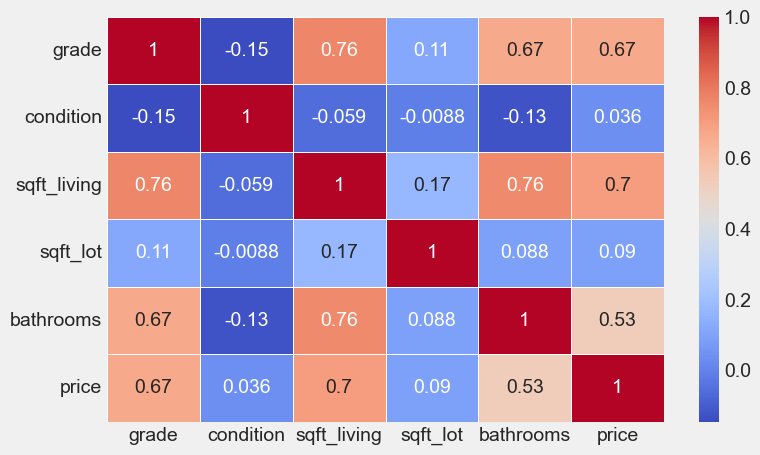

In [305]:
## Check for Correlations
# correlation matrix between these variables
corr_columns=["grade", "condition", "sqft_living", "sqft_lot", "bathrooms", "price"]
corr_mtrx=df_detailed_sales[corr_columns].corr()
corr_mtrx
#plt.figure(figsize = (14,12))
ax = sns.heatmap(corr_mtrx, linewidths=.5, annot=True, cmap='coolwarm')

We see that there is a strong correlation between the following variables:
 - sqft_living and price
 - sqft_living and bathrooms (!)
-  but not so strong: bathrooms and price.

Good indicators for the price seem to be (>.6): grade, sqft_living,

### Find 'poor neighbourhoods'

We want to offer 'affordable' houses in poorer neighbourhoods. We define "neighbourhood" as all houses within one ZIPCODE (which is not 100% correct). Now we want to know which neighbourhoods are 'poor'. The definition of poverty is "below 60% of the median income". We thus say: A poor neighbourhood is one in which the prices are 60% of the overall median price.

So how to proceed?
 2. We calculate the median of all (ungrouped!) house prices.
 3. We find the "poverty threshold" by multiplying it with .6
 1. We group all house sales by ZIP.
 4. ~~We show all ZIP groups where the maximum value is below the threshhold.~~
 5. Since this is probably too few, we also look at the median of the group instead.

In [306]:
# Repair double columns in detailed sales.
# This actually deletes BOTH 'id' columns, even though we tell pandas to
# delete only the last one. Seems to be the same object? Or maybe it's the argument
# 'col', which is matched with both columns.
n_col = len(df_detailed_sales.columns) - 1
col = df_detailed_sales.columns[n_col]
if col == 'id':
    df_detailed_sales.drop(col, axis=1, inplace=True)
    print(f"Deleted column {col}")
else:  
    print("No column'id' at the end; did nothing.")

print(df_detailed_sales.columns)


Deleted column id
Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'date', 'price', 'house_id'],
      dtype='object')


Find all houses with 'poor' prices

In [307]:
# Find the poverty threshold
median = df_detailed_sales['price'].median() # 450.000
poverty_threshold = median*0.6   # 270.000

# Find the houses in the poor neighbourhood
poor_zips=df_detailed_sales.groupby('zipcode')['price'].mean() <= poverty_threshold
df_poor_zips = poor_zips.to_frame().reindex()
#df_poor_zips
df_merged=df_detailed_sales.merge(poor_zips, on='zipcode', how='left')
poor_houses=df_merged[df_merged['price_y']]
poor_houses.rename(columns={'price_x': 'price'}, inplace=True)


For the presentation, show which range is '60% of the median':

270000.0


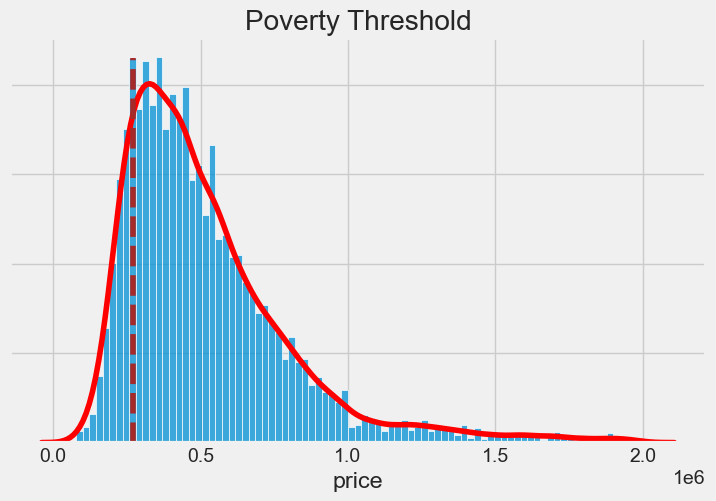

In [308]:
fig, ax = plt.subplots()
sample = df_detailed_sales.query('price < 2000000')
sns.set_style('white')
sns.histplot(sample, x='price', stat='density')
sns.kdeplot(sample, x='price', color='red')
plt.axvline(poverty_threshold, 0, 0.95, color='brown', linestyle='--')
plt.title('Poverty Threshold')
ax.set_ylabel('')
ax.set_yticklabels([])
print(poverty_threshold)

#(2.4, 0, 0.95, color='brown', linestyle='--')

# of houses in poor neighbourhood: 593


Text(0.5, 1.0, 'Cheaper Houses in King County')

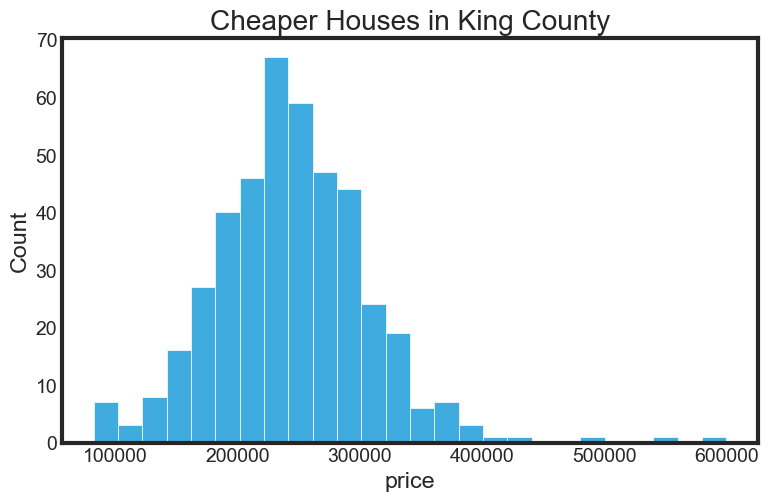

In [309]:
# Get some info on the results:
print("# of houses in poor neighbourhood:", poor_houses.shape[0])
# How is it distributed?
fig, ax = plt.subplots()
sns.histplot(poor_houses.groupby('price').value_counts(), x='price')
ax.set_title('Cheaper Houses in King County')


In [310]:
poor_houses.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'date', 'price', 'house_id', 'price_y'],
      dtype='object')

## Create a Geographic Map

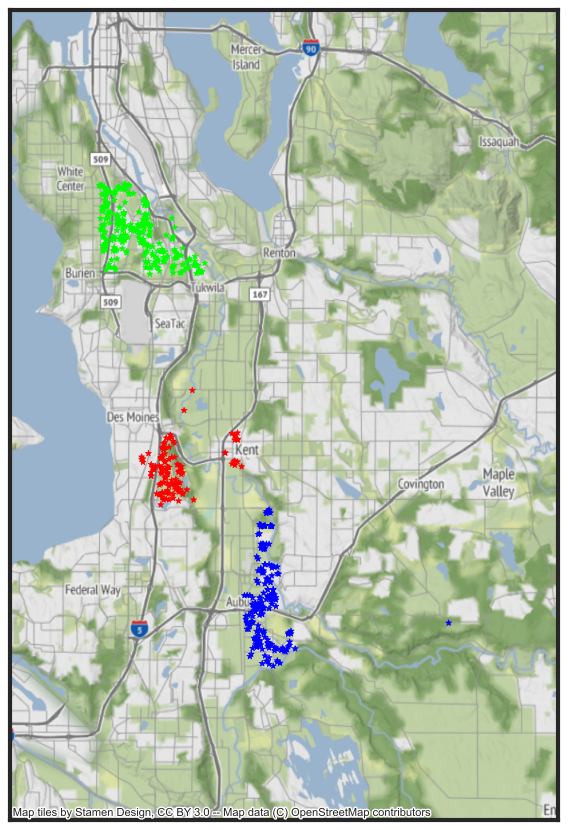

In [329]:
#https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as cx
import matplotlib.colors as colors

# create colormap
def set_color(row):
    """Set color per zip code."""
    if row['zipcode'] == 98002:
       return '#0000ff'
    elif row['zipcode'] == 98168:
        return '#00ff00'
    else:
        return '#ff0000'

poor_houses['color']=poor_houses.apply(set_color, axis=1)

# set coordinate reference system and map the coordinates accordingly
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(poor_houses['long'], poor_houses['lat'])]
gdf=gpd.GeoDataFrame(poor_houses, geometry = geometry, crs=crs)
gdf.to_crs(crs['init']);


# the acutal plot:
fig, ax = plt.subplots(figsize=(10,10))

x_min, x_max = -122.4, -122.0 # zooming box
y_min, y_max = 47.2, 47.6
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_xticklabels(labels=[])
ax.set_yticklabels(labels=[])

# add basemap and plot the points
cx.add_basemap(ax, crs=gdf.crs)
gdf.plot(ax=ax,
         zorder=99, # if there is a shape map
         color = poor_houses['color'],
         marker='*', label='King County', markersize=20)
plt.show()

Create a list with the ZIP codes and their respective colors for the presentation:

In [314]:
poor_houses.groupby('zipcode')['color'].value_counts()

zipcode  color  
98002    #0000ff    199
98032    #ff0000    125
98168    #00ff00    269
Name: count, dtype: int64

Now limit to those houses which are in good condition and which are graded decently (see above)

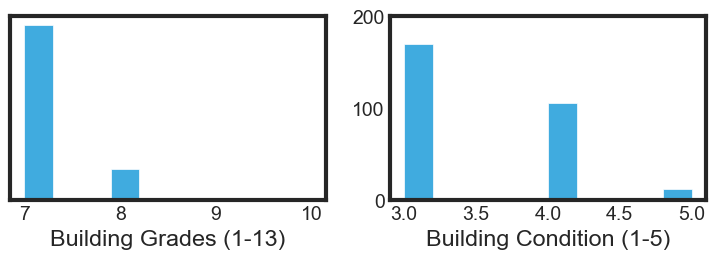

In [315]:
good_poor_houses = poor_houses[(poor_houses['condition'] >= 3)
                               & (poor_houses['grade'] >= 7)]

fig, ax = plt.subplots(2,2)
sns.histplot(good_poor_houses.groupby('grade').value_counts(), x='grade', ax=ax[0][0])
sns.histplot(good_poor_houses.groupby('condition').value_counts(), x='condition', ax=ax[0][1])
ax[0][0].set_ylabel('')
ax[0][0].set_xlabel('Building Grades (1-13)')
ax[0][1].set_ylabel('')
ax[0][1].set_xlabel('Building Condition (1-5)')
ax[0][1].set_yticks([0,100,200])
ax[0][0].set_yticks([])
fig.delaxes(ax[1][0])
fig.delaxes(ax[1][1])

# Conclusions

For investments, it is receommended to buy houses with condition '3' and invest in their renovation.

Let's check if there are many renovated houses already.

In [316]:
# get all houses with condition==3 
investments = good_poor_houses[['house_id','price','condition','yr_renovated']].query('condition == 3').copy()
# clean up the 'yr_renovated' row:
investments['yr_renovated'].fillna(0, inplace=True)
# add a boolean column on 'renovated?'
investments['yr_renovated']=investments.yr_renovated.map(lambda x: x/10)
investments['renovated']=investments['yr_renovated'] != 0
print(investments.shape[0])
investments.query('renovated')


223


,house_id,price,condition,yr_renovated,renovated
3800,8075400530,234000.000,3,2013.000,True
9808,3832700250,270000.000,3,1985.000,True
13586,7345310100,238000.000,3,1993.000,True
16856,798000457,235000.000,3,1984.000,True
17188,2648000071,225000.000,3,2001.000,True


Looks good - only 5 houses from 223, that's 2%, have been revonated at all, and quite some time ago.

In [317]:
df_details.columns

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [318]:
# How old are these houses?
#first let's get a full list of houses:
investment_details = df_detailed_sales.merge(investments['house_id'], how='inner', on='house_id').copy()
# now group by yt_built
#investment_details.columns
investment_details.groupby('yr_built').value_counts()

yr_built  bedrooms  bathrooms  sqft_living  sqft_lot   floors  waterfront  view   condition  grade  sqft_above  sqft_basement  yr_renovated  zipcode  lat     long      sqft_living15  sqft_lot15  date        price       house_id  
1921      2.000     1.500      1820.000     8867.000   2.000   0.000       0.000  3          7      1820.000    0.000          0.000         98168    47.476  -122.269  1430.000       9288.000    2014-06-18  206000.000  1670400068    1
1926      4.000     1.000      1340.000     22500.000  1.500   0.000       0.000  3          7      1340.000    0.000          0.000         98168    47.489  -122.316  1620.000       10800.000   2014-09-18  275000.000  8018600640    1
1928      4.000     1.000      1380.000     6700.000   1.000   0.000       0.000  3          7      1190.000    190.000        0.000         98168    47.487  -122.281  1380.000       8292.000    2014-08-06  185000.000  7340600845    1
1931      3.000     1.500      1800.000     22000.000  2.000   0.

We have a span from 1921 to 2014. So assuming that it is more expensive to renovate an older house, we can create three categories by dividing the span in thirds. The 'oldest' category then would be the one with the highest costs in investment.

In [319]:
yr_min = investment_details.yr_built.min()
yr_max = investment_details.yr_built.max()
list(range(yr_min, yr_max, round((yr_max - yr_min) / 3))) # [1921, 1952, 1983]
# so we have three ranges: 1921-1952; 1953-1983; 1984-yr_max.
# let's call them range 3, 2, 1, and add it to the data:

def find_range(row):
    """Return a range indicator for ROW."""
    if row['yr_built'] < 1953:
        return 3
    elif row['yr_built'] < 1983:
        return 2
    else:
        return 1
    
investment_details['range']=investment_details.apply(find_range, axis=1)

# Show the groups:
print(investment_details.groupby('range')['range'].count())


range
1     81
2    122
3     26
Name: range, dtype: int64


In [320]:
# Just to double check: Show me the years of the range 1 (should be the newest buildings)
investment_details.query('range == 1')['yr_built'].describe()

count     81.000
mean    2004.346
std        8.444
min     1985.000
25%     1997.000
50%     2006.000
75%     2012.000
max     2014.000
Name: yr_built, dtype: float64

In [321]:
# Get some info on the price ranges:
investment_details.groupby('range')['price'].describe()



,count,mean,std,min,25%,50%,75%,max
range,,,,,,,,
1,81.000,291309.938,59294.146,163000.000,260000.000,280000.000,300000.000,600000.000
2,122.000,254381.844,58080.951,135000.000,220000.000,252500.000,289250.000,406500.000
3,26.000,245432.692,61768.181,150000.000,201500.000,242500.000,282000.000,360000.000


Let's visualize that for the client:

Text(0, 0.5, '')

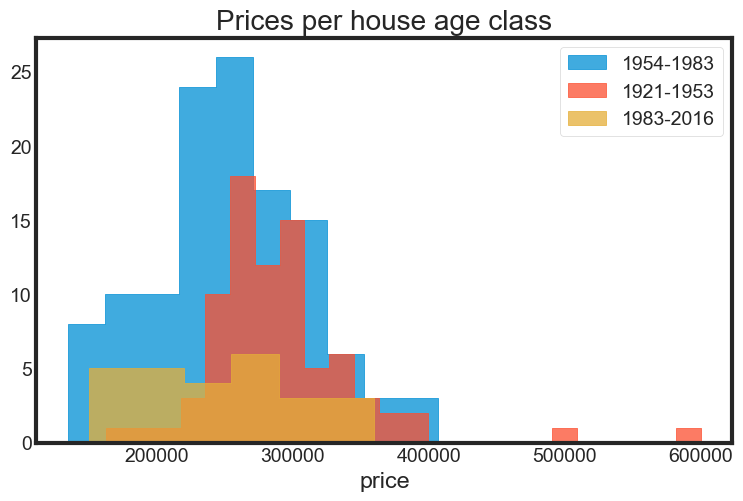

In [323]:
# we want: y-axis = price; sorted by price.
fig, ax = plt.subplots()
r2=sns.histplot(investment_details.query('range == 2'), x='price', element='step', fill='false',
                label='1954-1983')
r1=sns.histplot(investment_details.query('range == 1'), x='price', element='step', fill='false',
                label='1921-1953')
r3=sns.histplot(investment_details.query('range == 3'), x='price', element='step', fill='false',
                label='1983-2016')

ax.set_title('Prices per house age class')
ax.legend(loc=1, fancybox=True)
ax.set_ylabel('')


In [325]:
good_poor_houses.condition.unique()

array([3, 4, 5])

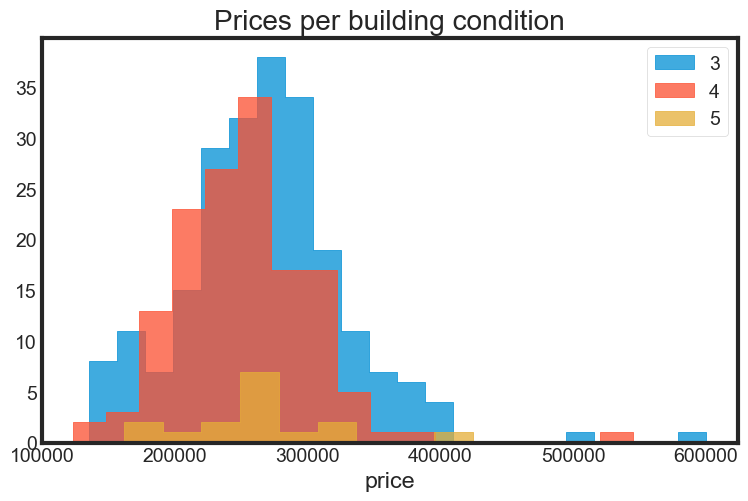

In [328]:
# we want: y-axis = price; sorted by building condition.
fig, ax = plt.subplots()

r2=sns.histplot(good_poor_houses.query('condition == 3'), x='price', element='step', fill='false', label='3')
r1=sns.histplot(good_poor_houses.query('condition == 4'), x='price', element='step', fill='false', label='4')
r3=sns.histplot(good_poor_houses.query('condition == 5'), x='price', element='step', fill='false', label='5')

ax.set_title('Prices per building condition')
ax.legend(loc=1, fancybox=True)
ax.set_ylabel('')
plt.show()

Look how the houses with condition == 4 are distributed:

214


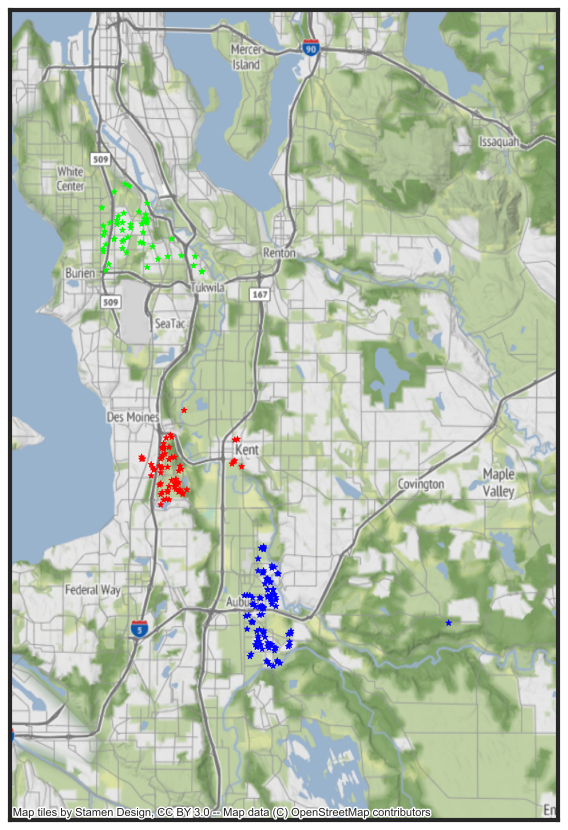

In [336]:
# Plot only those houses with condition==4

query = 'condition == 4'
print(poor_houses.query(query).shape[0])
geometry = [Point(xy) for xy in zip(poor_houses.query(query)['long'],
                                    poor_houses.query(query)['lat'])]
gdf=gpd.GeoDataFrame(poor_houses.query(query), geometry = geometry, crs=crs)
gdf.to_crs(crs['init']);

fig, ax = plt.subplots(figsize=(10,10))

x_min, x_max = -122.4, -122.0 # zooming box
y_min, y_max = 47.2, 47.6
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_xticklabels(labels=[])
ax.set_yticklabels(labels=[])

# add basemap and plot the points
cx.add_basemap(ax, crs=gdf.crs)
gdf.plot(ax=ax,
         zorder=99, # if there is a shape map
         color = poor_houses.query(query)['color'],
         marker='*', label='King County', markersize=20)
plt.show()

This is not very informative. So let' tell the client the prices instead:

<Axes: xlabel='price', ylabel='Count'>

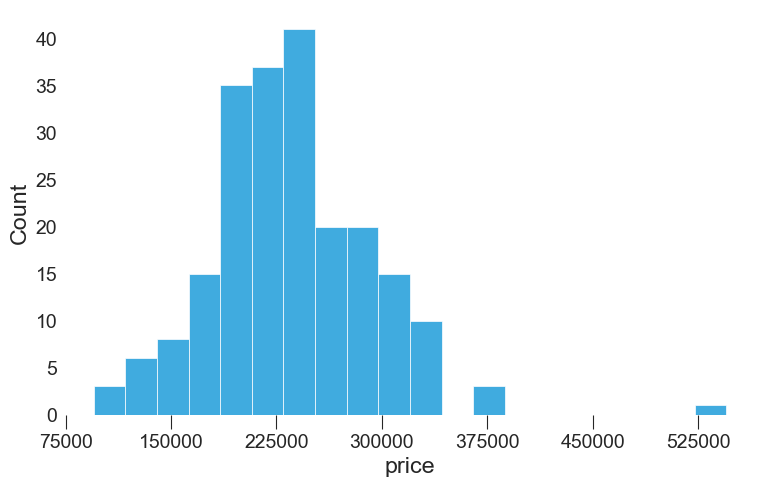

In [389]:
# show the prices 
query = 'condition==4'

# show more ticker values
import matplotlib.ticker as ticker
fig,ax=plt.subplots()
loc = ticker.MultipleLocator(base=75000)

ax.set_ylabel('')
ax.xaxis.set_major_locator(loc)
for pos in ax.spines:
    ax.spines[pos].set_visible(False)
ax.tick_params(reset=True, length=10, axis='x', direction='out', top=False)
sns.histplot(poor_houses.query(query), x='price')

# This is the end (special title for the outline)